In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import sys

sys.path.append("../../")
from lib.general import get_stage_list

### Input

In [2]:
# Define I/O paths
path_demographics: Path = Path(
    "../../../data/processed/adni/demographics_biomarkers.csv"
).resolve()
path_converters: Path = Path(
    "../../../data/processed/adni/converters_to_ad.csv"
).resolve()
# path_lipidomics: Path = Path("../../../data/processed/adni/lipidomics.csv").resolve()
path_output_table: Path = Path("../../../assets/tables/adni/").resolve()

In [3]:
# Read files
df_demographics: pd.DataFrame = pd.read_csv(path_demographics).convert_dtypes()
df_converters: pd.DataFrame = pd.read_csv(path_converters).convert_dtypes()
# df_lipidomics: pd.DataFrame = pd.read_csv(path_lipidomics).convert_dtypes()

### Process

In [4]:
# Join dataframes
df_raw: pd.DataFrame = df_demographics.join(
    df_converters.set_index("RID"), on="RID", how="inner"
)  # .join(df_lipidomics.set_index("RID"), on="RID", how="inner")

In [5]:
df_raw["visit_month"].describe()

count        570.0
mean     61.189474
std      38.084301
min            0.0
25%           24.0
50%           48.0
75%           96.0
max          144.0
Name: visit_month, dtype: Float64

In [6]:
# Compare survival between the four stages
level_order: list[str] = get_stage_list(2)
df_raw["level"] = pd.Categorical(df_raw["stage"], categories=level_order, ordered=True)

In [7]:
# Inclusion criterion: cognitive status diagnosis at baseline
# Select one of the following: {"CN", "MCI", "combined"}
option: str = "MCI"

In [8]:
# Subset data
options: dict[str, list[int]] = {"CN": [0], "MCI": [1], "combined": [0, 1]}
df_raw: pd.DataFrame = df_raw.loc[df_raw["cog"].isin(options[option])].reset_index(
    drop=True
)

### Available follow-up

In [9]:
# Instantiate follow-up timestamps
timestamps: np.ndarray = np.arange(0, 12 * 13, 12)
available_followup = pd.DataFrame(columns=timestamps, index=df_raw["RID"])

In [10]:
# For each participant, check if follow-up is available at each timestamp
for participant, max_visit in zip(df_raw["RID"], df_raw["visit_month"]):
    available_followup.loc[participant] = (max_visit >= timestamps).astype(bool)

In [11]:
# Add level to available follow-up
available_followup["level"] = df_raw.set_index("RID")["level"]

In [12]:
# Display number of available follow-up visits per level
df_followup: pd.DataFrame = (
    available_followup.groupby(by="level", observed=True)
    .sum()
    .sort_index(axis=0, ascending=True)
)

### Prepare data for analysis

In [13]:
# Subset to consider only CN (cog == 0) or MCI (cog == 1) participants at once
df: pd.DataFrame = df_raw[["RID", "level", "converted", "convert_month"]]

In [14]:
# Display the number and fraction of converters per level
df_count: pd.DataFrame = (
    df.groupby(by="level", observed=True)["converted"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "N", "sum": "N (%) converted", "mean": "fraction"})
    .sort_index(axis=0, ascending=True)
)
df_count["N (%) converted"] = (
    df_count["N (%) converted"].astype(str)
    + " ("
    + (df_count["fraction"] * 100).round(0).astype(int).astype(str)
    + ")"
)
df_count: pd.DataFrame = df_count.drop(columns=["fraction"])

### Kaplan-Meier analysis

In [15]:
# Set matplotlib parameters
plt.rcParams.update(
    {"font.size": 12, "font.family": "Arial", "figure.figsize": (10, 6)}
)

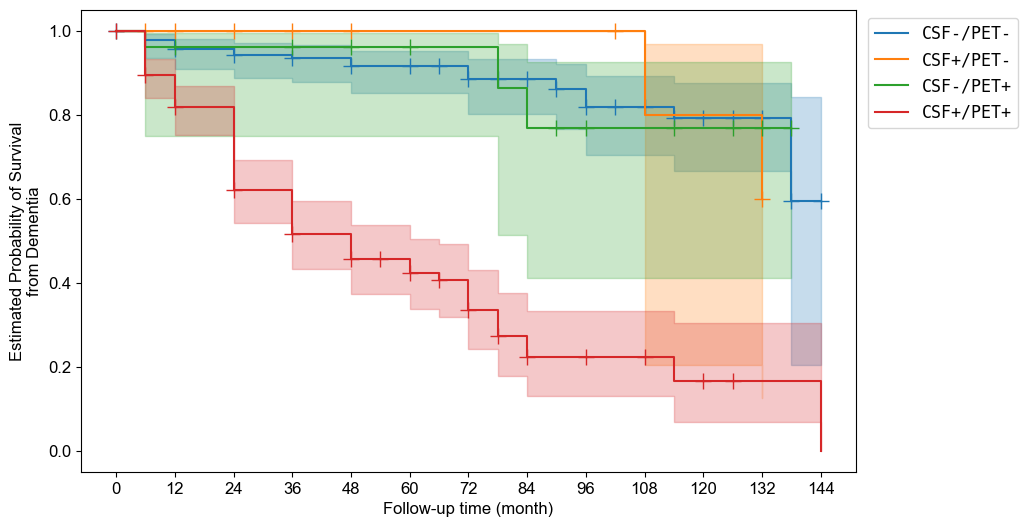

In [16]:
# Plot Kaplan-Meier curve for each level
for level in level_order:
    df_level: pd.DataFrame = df.loc[df["level"] == level].reset_index(drop=True)
    kmf = KaplanMeierFitter()
    kmf.fit(
        durations=df_level["convert_month"],
        event_observed=df_level["converted"],
        label=level,
    )
    show_ci = True
    kmf.plot(show_censors=True, ci_show=show_ci, ax=plt.gca(), label=level)
plt.legend(loc="upper right", bbox_to_anchor=(1.22, 1), prop={"family": "monospace"})
plt.xticks(range(0, 12 * 13, 12))
plt.xlabel("Follow-up time (month)")
plt.ylabel("Estimated Probability of Survival\nfrom Dementia")
plt.show()

### Log-rank comparison

In [17]:
# Subset by level
subset_1: pd.DataFrame = df.loc[df["level"] == level_order[1]].reset_index(drop=True)
subset_2: pd.DataFrame = df.loc[df["level"] == level_order[2]].reset_index(drop=True)

In [18]:
# LogRank test comparing two levels
p_val: float = logrank_test(
    subset_1["convert_month"],
    subset_2["convert_month"],
    subset_1["converted"],
    subset_2["converted"],
    alpha=0.95,
).p_value
f"LogRank test p-value = {p_val:.5f}"

'LogRank test p-value = 0.86172'

### Cox regression

In [19]:
# Define comparison scope and reference group
comparison_scope: list[str] = level_order.copy()  # include all levels
reference_group: str = comparison_scope[0]  # use the first included level as reference

In [20]:
# k-1 dummy variables are needed to represent k groups
dummy_scope: list[str] = comparison_scope.copy()
dummy_scope.remove(reference_group)

In [21]:
# Subset to comparison scope
subset: pd.DataFrame = df.loc[df["level"].isin(comparison_scope)].reset_index(drop=True)
# Expand the levels to dummy variables
df_dummies: pd.DataFrame = pd.get_dummies(
    subset, columns=["level"], prefix="", prefix_sep="", drop_first=False, dtype=bool
).set_index("RID")

In [22]:
# Fit Cox Proportional Hazards model
cph: CoxPHFitter = CoxPHFitter(penalizer=0.1)
cph.fit(
    df_dummies[["converted", "convert_month"] + dummy_scope],
    duration_col="convert_month",
    event_col="converted",
)

<lifelines.CoxPHFitter: fitted with 365 total observations, 245 right-censored observations>

In [23]:
# Display model summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 365 total observations, 245 right-censored observations>
             duration col = 'convert_month'
                event col = 'converted'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 365
number of events observed = 120
   partial log-likelihood = -594.54
         time fit was run = 2025-11-02 19:32:37 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
CSF+/PET- -0.30      0.74      0.51           -1.30            0.70                0.27                2.02
CSF-/PET+ -0.33      0.72      0.42           -1.14            0.49                0.32                1.64
CSF+/PET+  1.45      4.26      0.18            1.10            1.80                2.99                6.07

           cmp to     z      p  -log2(p)
covariate                               
CSF+/PET-    0.00 -0.59   0.56      0.84
CSF-/PET+    0.00 -0.78   0.44      1.20
CSF+/PET+    0.00  8.03 <0.005     49.92
---
Concordance = 0.74
Partial AIC = 1195.08
log-likelihood ratio test = 79.48 on 3 df
-log2(p) of ll-ratio test = 54.48

### Output

In [24]:
# Extract model summary for output
df_cph: pd.DataFrame = cph.summary.copy(deep=True)
df_cph["HR"] = (
    df_cph["exp(coef)"].round(2).astype(str)
    + " ["
    + df_cph["exp(coef) lower 95%"].round(2).astype(str)
    + ", "
    + df_cph["exp(coef) upper 95%"].round(2).astype(str)
    + "]"
)
df_cph["p"] = df_cph["p"].apply(lambda x: "< 0.001" if x < 0.001 else f"{x:.3f}")

In [25]:
# Compose output table
df_final: pd.DataFrame = df_count.join(df_cph[["HR", "p"]], on=None, how="left").join(
    df_followup, on=None, how="left"
)
df_final.index.name = None

In [26]:
# Display output table
df_final

,N,N (%) converted,HR,p,0,12,24,36,48,60,72,84,96,108,120,132,144
CSF-/PET-,148,18 (12),NaN,NaN,148,141,133,118,103,77,62,55,42,33,24,13,2
CSF+/PET-,16,2 (12),"0.74 [0.27, 2.02]",0.558,16,15,13,12,8,6,6,6,6,5,4,4,0
CSF-/PET+,25,3 (12),"0.72 [0.32, 1.64]",0.435,25,25,19,19,16,13,10,9,8,6,5,3,0
CSF+/PET+,176,97 (55),"4.26 [2.99, 6.07]",< 0.001,176,167,149,122,93,64,35,27,17,8,5,1,1


In [27]:
# Save to CSV
df_final.to_csv(path_output_table / f"survival_{option}.csv", index=True)